In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler



from scipy.stats import shapiro, normaltest
from category_encoders import HashingEncoder



import warnings
warnings.filterwarnings('ignore')

In [140]:
df = pd.read_csv('../data/train_cleaned.csv', keep_default_na=False)

In [141]:
df.drop(columns=['Id'], inplace=True)

In [142]:
# 1. QUANTITATIVE (Numerical) - Continuous/Discrete
QUANTITATIVE_COLS  = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars','HouseAge', 'TotalSF', 'TotalPorchSF', 'TotalBsmtFinSF', 'SalePrice'
]


QUANTITATIVE_COLS_UPDATED = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
 '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath',
 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces','GarageCars',  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
 '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# 2. ORDINAL (Categorical with order/ranking)
ORDINAL_COLS = ['Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
              'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
              'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'YrSold', 'MoSold']


# 3. NOMINAL (Categorical without order)
NOMINAL_COLS = list(set(df.columns) - set(QUANTITATIVE_COLS + ORDINAL_COLS + ['SalePrice']))
NOMINAL_COLS.remove('CentralAir')
# 4. BINARY
BINARY_COLS = [
    'CentralAir', 'HasPool',
    'HasGarage', 'HasBsmt',
    'HouseRemodeled'
]

### Mappings

In [143]:
ordinal_mappings = {
    # Exterior Quality & Condition (5-point scale)
    'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},

    # Basement Quality (height-based)
    'BsmtQual': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},

    # Basement Exposure
    'BsmtExposure': {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},

    # Basement Finished Type
    'BsmtFinType1': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType2': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},

    # Heating Quality
    'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},

    # Kitchen Quality
    'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},

    # Functional
    'Functional': {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8},

    # Fireplace Quality
    'FireplaceQu': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},

    # Garage Finish
    'GarageFinish': {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},

    # Garage Quality & Condition
    'GarageQual': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},

    # Paved Drive
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},

    # Pool Quality
    'PoolQC': {'NA': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},

    # Fence Quality
    'Fence': {'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},

    # Lot Shape (regularity)
    'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4},

    # Land Slope
    'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3},

    # Utilities
    'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4}
}

In [144]:
df[BINARY_COLS].head()

,CentralAir,HasPool,HasGarage,HasBsmt,HouseRemodeled
0,Y,0,1,1,0
1,Y,0,1,1,0
2,Y,0,1,1,1
3,Y,0,1,1,1
4,Y,0,1,1,0


In [ ]:
def encode_features(
    df,
    ordinal_mappings,
    nominal_cols,
    binary_features=None,
    high_card_threshold=9,
    n_hash_features=10
):
    df_encoded = df.copy()

    if binary_features is None:
        binary_features = []

    # Binary columns (CentralAir)
    if 'CentralAir' in df_encoded.columns:
        df_encoded['CentralAir'] = df_encoded['CentralAir'].map({'N': 0, 'Y': 1})
        print(f"Encoded binary: CentralAir")

    # Ordinal Colums
    for col, mapping in ordinal_mappings.items():
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map(mapping)
            print(f"Encoded ordinal: {col}")

    # Binary Columns
    for col in binary_features:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].astype(int)
            print(f"Kept binary feature: {col}")

    # Nominal Encoding
    nominal_cols = [
        col for col in nominal_cols
        if col in df_encoded.columns and col not in binary_features
    ]

    low_card_cols = [
        col for col in nominal_cols
        if df_encoded[col].nunique() < high_card_threshold
    ]

    high_card_cols = [
        col for col in nominal_cols
        if df_encoded[col].nunique() >= high_card_threshold
    ]

    # OHE (Low-cardinality)
    if low_card_cols:
        df_encoded = pd.get_dummies(
            df_encoded,
            columns=low_card_cols,
            drop_first=True
        )
        print(f"One-hot encoded {len(low_card_cols)} nominal columns")

    # Hashing Encoding (High-cardinality)
    if high_card_cols:
        encoder = HashingEncoder(
            n_components=n_hash_features,
            return_df=True
        )
        hashed_df = encoder.fit_transform(df_encoded[high_card_cols])

        df_encoded = df_encoded.drop(columns=high_card_cols)
        df_encoded = pd.concat([df_encoded, hashed_df], axis=1)

        print(f"Hashed {len(high_card_cols)} high-cardinality nominal columns")
        df_encoded['HouseRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
        df_encoded['HasPool'] = (df['PoolArea'] > 0).astype(int)
        df_encoded['HasGarage'] = (~df['GarageType'].isin(['None', 'NA', np.nan])).astype(int)
        df_encoded['HasBsmt'] = (~df['BsmtQual'].isin(['None', 'NA', np.nan])).astype(int)
        print(f"Hashed Columns: {high_card_cols}")
        cols_to_drop = [
            'YearBuilt', 'YrSold', 
            'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
            'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF',
            'BsmtFinSF1', 'BsmtFinSF2'
        ]

        df_encoded.drop(columns=cols_to_drop, inplace=True)
    
    return df_encoded


In [176]:
final_df_encoded = encode_features(df,ordinal_mappings, NOMINAL_COLS)

Encoded binary: CentralAir
Encoded ordinal: ExterQual
Encoded ordinal: ExterCond
Encoded ordinal: BsmtQual
Encoded ordinal: BsmtCond
Encoded ordinal: BsmtExposure
Encoded ordinal: BsmtFinType1
Encoded ordinal: BsmtFinType2
Encoded ordinal: HeatingQC
Encoded ordinal: KitchenQual
Encoded ordinal: Functional
Encoded ordinal: FireplaceQu
Encoded ordinal: GarageFinish
Encoded ordinal: GarageQual
Encoded ordinal: GarageCond
Encoded ordinal: PavedDrive
Encoded ordinal: PoolQC
Encoded ordinal: Fence
Encoded ordinal: LotShape
Encoded ordinal: LandSlope
Encoded ordinal: Utilities
One-hot encoded 24 nominal columns
Hashed 6 high-cardinality nominal columns
Hashed Columns: ['Exterior2nd', 'Neighborhood', 'SaleType', 'Exterior1st', 'MSSubClass', 'Condition1']


### Scaling

In [147]:
def visualize_distributions_for_scaling(df, numeric_cols):
    fig, axes = plt.subplots(len(numeric_cols), 4, figsize=(20, len(numeric_cols)*3))
    fig.suptitle('Data Distribution', fontsize=16, y=1.002)

    # kalau cuma 1 kolom, ubah axis jadi 2D biar indexing aman
    if len(numeric_cols) == 1:
        axes = np.array([axes])

    for idx, col in enumerate(numeric_cols):
        data = df[col].dropna()
        if data.empty:
            continue

        Q1, Q3 = data.quantile([0.25, 0.75])
        skew = data.skew()
        kurt = data.kurtosis()

        def plot_hist(ax, values, title, color):
            sns.histplot(values, bins=30, kde=True, ax=ax, color=color, alpha=0.7, edgecolor='black')
            ax.axvline(Q1, color='blue', linestyle='--', label='Q1')
            ax.axvline(Q3, color='blue', linestyle='--', label='Q3')
            ax.set_title(f'{title}\nSkew={skew:.2f} | Kurt={kurt:.2f}', fontsize=9)
            ax.legend(fontsize=7)

        plot_hist(axes[idx, 0], data, f'{col}\nOriginal', 'gray')

        scaled_std = StandardScaler().fit_transform(data.values.reshape(-1, 1))
        plot_hist(axes[idx, 1], scaled_std, 'StandardScaler (Mean=0, Std=1)', 'orange')

        scaled_minmax = MinMaxScaler().fit_transform(data.values.reshape(-1, 1))
        plot_hist(axes[idx, 2], scaled_minmax, 'MinMaxScaler (0–1)', 'green')

        scaled_robust = RobustScaler().fit_transform(data.values.reshape(-1, 1))
        plot_hist(axes[idx, 3], scaled_robust, 'RobustScaler (Median-based)', 'red')

    plt.tight_layout()
    plt.show()

In [148]:
cols_to_scale = [
    col for col in QUANTITATIVE_COLS
    if col != 'SalePrice' and col in final_df_encoded.columns
]

# visualize_distributions_for_scaling(final_df_encoded, cols_to_scale)

Insight:
- Some of the  numeric columns are actually categorical or ordinal in nature
(OverallQual, OverallCond, Fireplaces, GarageCars, FullBath, HalfBath, BsmtFullBath, BsmtHalfBath, BedroomAbvGr, KitchenAbvGr, MoSold, YrSold), scaling is not applied
- Several columns show right-skewed distributions especially in size-related (LotArea, GrLivArea)
- Time-based columns habve large magnitude, needed to scale to the red-uce their influence to other columns

In [149]:
def calculate_outlier_percentage(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((data < lower) | (data > upper)).sum()
    outlier_pct = (outliers / len(data)) * 100
    return outliers, outlier_pct

def recommend_scaler_with_reason(skewness, outlier_pct):
    if outlier_pct > 5:
        return 'RobustScaler', 'Contains more than 5% outliers, so RobustScaler is more stable against extreme values.'
    elif abs(skewness) > 1:
        return 'RobustScaler', 'Distribution is highly skewed (|skew| > 1), thus RobustScaler is more appropriate.'
    else:
        return 'StandardScaler', 'Distribution is relatively normal and outliers are minimal, so StandardScaler is suitable.'


def scaling_statistical_analysis(df, numeric_cols):
    analysis_results = []
    for col in numeric_cols:
        data = df[col].dropna()
        if data.empty:
            continue

        skew = data.skew()
        kurt = data.kurtosis()
        outliers, outlier_pct = calculate_outlier_percentage(data)
        scaler, reason = recommend_scaler_with_reason(skew, outlier_pct)
        distrib = 'Skewed' if abs(skew) > 1 else 'Normal'

        analysis_results.append({
            'Column': col,
            'Skewness': round(skew, 6),
            'Kurtosis': round(kurt, 6),
            'Outliers (%)': round(outlier_pct, 6),
            'Distribusi': distrib,
            'Recommended': scaler,
            'Alasan Pemilihan': reason
        })

    results_df = pd.DataFrame(analysis_results)
    print(results_df[['Column', 'Skewness', 'Kurtosis', 'Outliers (%)', 'Distribusi', 'Recommended']].to_string(index=False))

    print("\n" + "="*80)
    print("Method Scaling Recommendation")
    print("="*80)
    print(results_df['Recommended'].value_counts())

    return results_df

In [150]:
scaler_summary = scaling_statistical_analysis(final_df_encoded, cols_to_scale)

        Column  Skewness   Kurtosis  Outliers (%) Distribusi    Recommended
   LotFrontage  2.409147  21.912954      7.260274     Skewed   RobustScaler
       LotArea 12.207688 203.243271      4.726027     Skewed   RobustScaler
    MasVnrArea  2.677616  10.141416      6.712329     Skewed   RobustScaler
     BsmtUnfSF  0.920268   0.474994      1.986301     Normal StandardScaler
  LowQualFinSF  9.011341  83.234817      1.780822     Skewed   RobustScaler
     GrLivArea  1.366560   4.895121      2.123288     Skewed   RobustScaler
    GarageArea  0.179981   0.917067      1.438356     Normal StandardScaler
      PoolArea 14.828374 223.268499      0.479452     Skewed   RobustScaler
       MiscVal 24.476794 701.003342      3.561644     Skewed   RobustScaler
  BsmtFullBath  0.596067  -0.839098      0.068493     Normal StandardScaler
  BsmtHalfBath  4.103403  16.396642      5.616438     Skewed   RobustScaler
      FullBath  0.036562  -0.857043      0.000000     Normal StandardScaler
      HalfBa

Insight:
- Many numeric features in the dataset are highly skewed (positively), as shown by skewness and kurtosis metrics.
(MiscVal, PoolArea, 3SsnPorch, LotArea, and LotFrontage showed extreme skewness (> 2) and very high kurtosis)
- For (MiscVal, PoolArea, 3SsnPorch, LotArea, and LotFrontage) columsn is the minimum columns to apply log transformation
- For skewed columns we;re goin to use robustscaler because it is resistant to outliers
- For Normal columns we're goin to use normal features

In [151]:
log_transform_cols = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'MiscVal', 'KitchenAbvGr', 'PoolArea',
    'TotRmsAbvGrd', 'TotalSF', 'TotalPorchSF'
]

remove_cols = [
    'YearBuilt', 'YrSold', 
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF',
    'BsmtFinSF1', 'BsmtFinSF2'
]


log_transform_cols = [c for c in log_transform_cols if c not in remove_cols]

final_df_encoded[log_transform_cols] = final_df_encoded[log_transform_cols].apply(np.log1p)

In [152]:
robust_cols = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'MiscVal', 'KitchenAbvGr', 'PoolArea', 'TotRmsAbvGrd', 'TotalSF', 'TotalPorchSF'
]

standard_cols = [
    'BsmtUnfSF', '2ndFlrSF', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars',
    'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold',
    'HouseAge', 'TotalBsmtFinSF'
]

robust_cols = [c for c in robust_cols if c not in remove_cols]
standard_cols = [c for c in standard_cols if c not in remove_cols]


In [153]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

scaled_final_df = final_df_encoded.copy()
scaled_final_df[robust_cols] = robust_scaler.fit_transform(scaled_final_df[robust_cols])
scaled_final_df[standard_cols] = standard_scaler.fit_transform(scaled_final_df[standard_cols])

### Multivariate Analysis

In [154]:
QUANTITATIVE_COLS_UPDATED = [c for c in QUANTITATIVE_COLS_UPDATED if c not in remove_cols]
ORDINAL_COLS = [c for c in ORDINAL_COLS if c not in remove_cols]

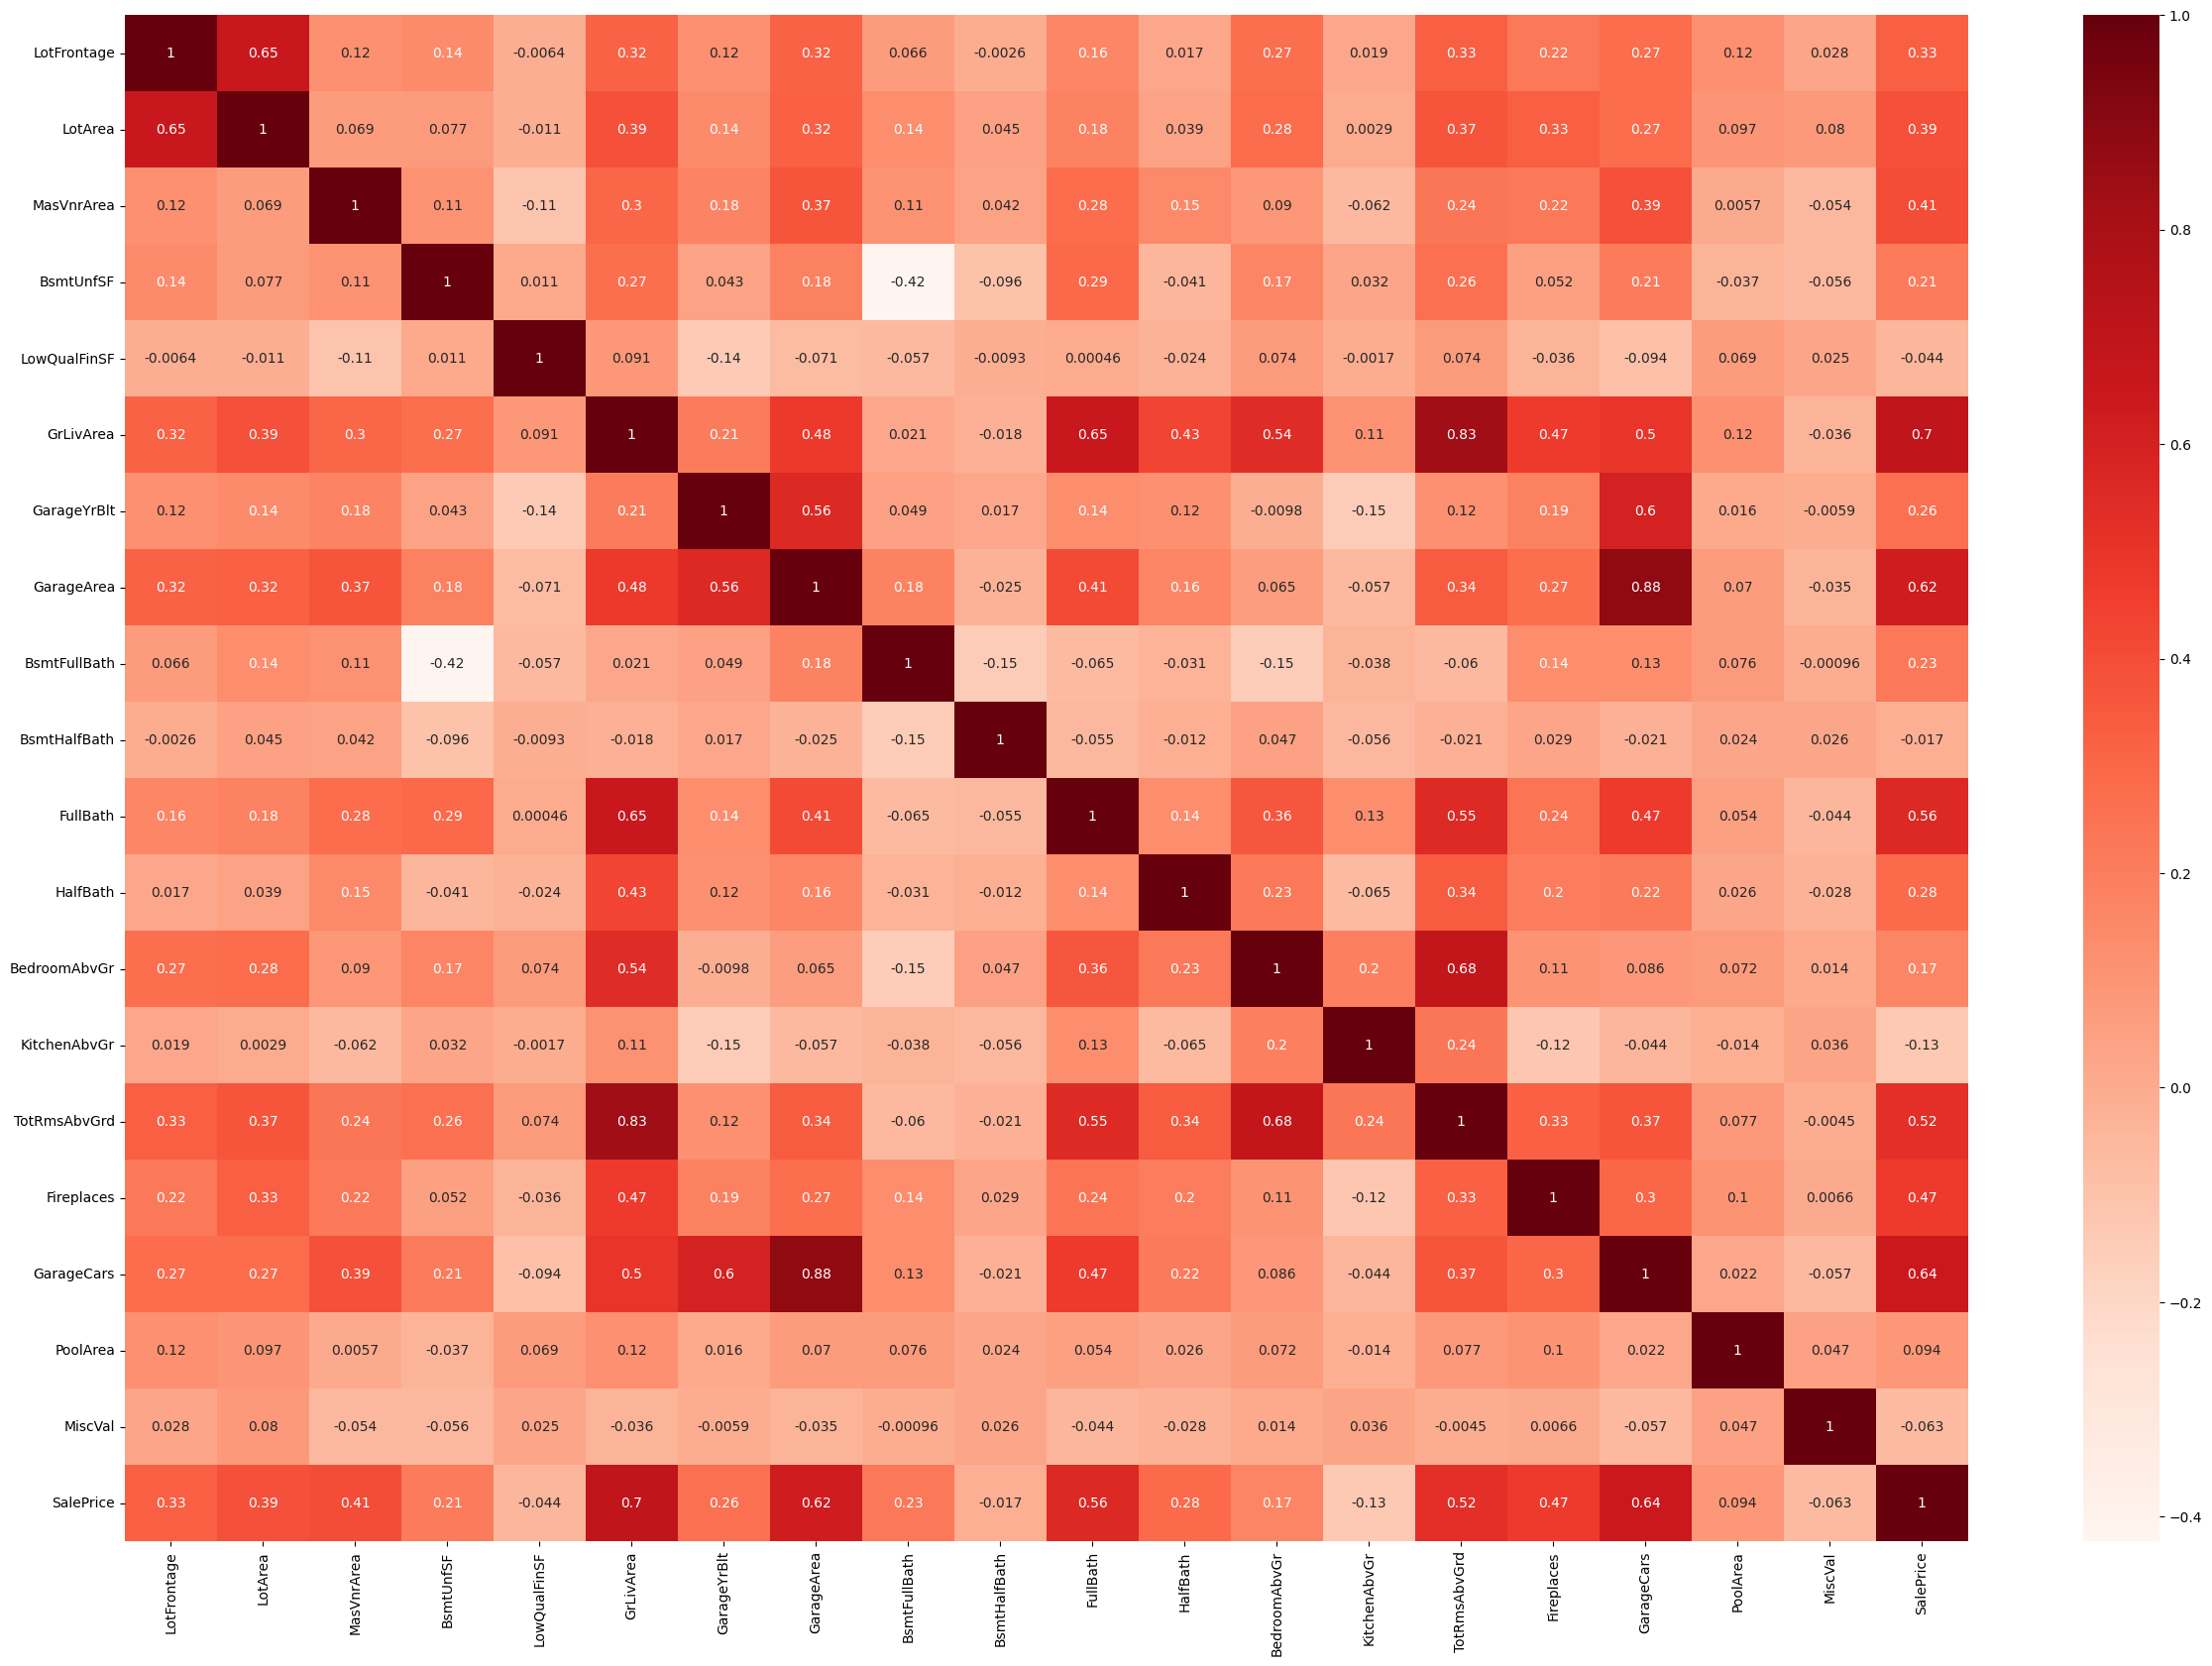

In [155]:
plt.figure(figsize=(30,20))
cor = scaled_final_df[QUANTITATIVE_COLS_UPDATED + ['SalePrice']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

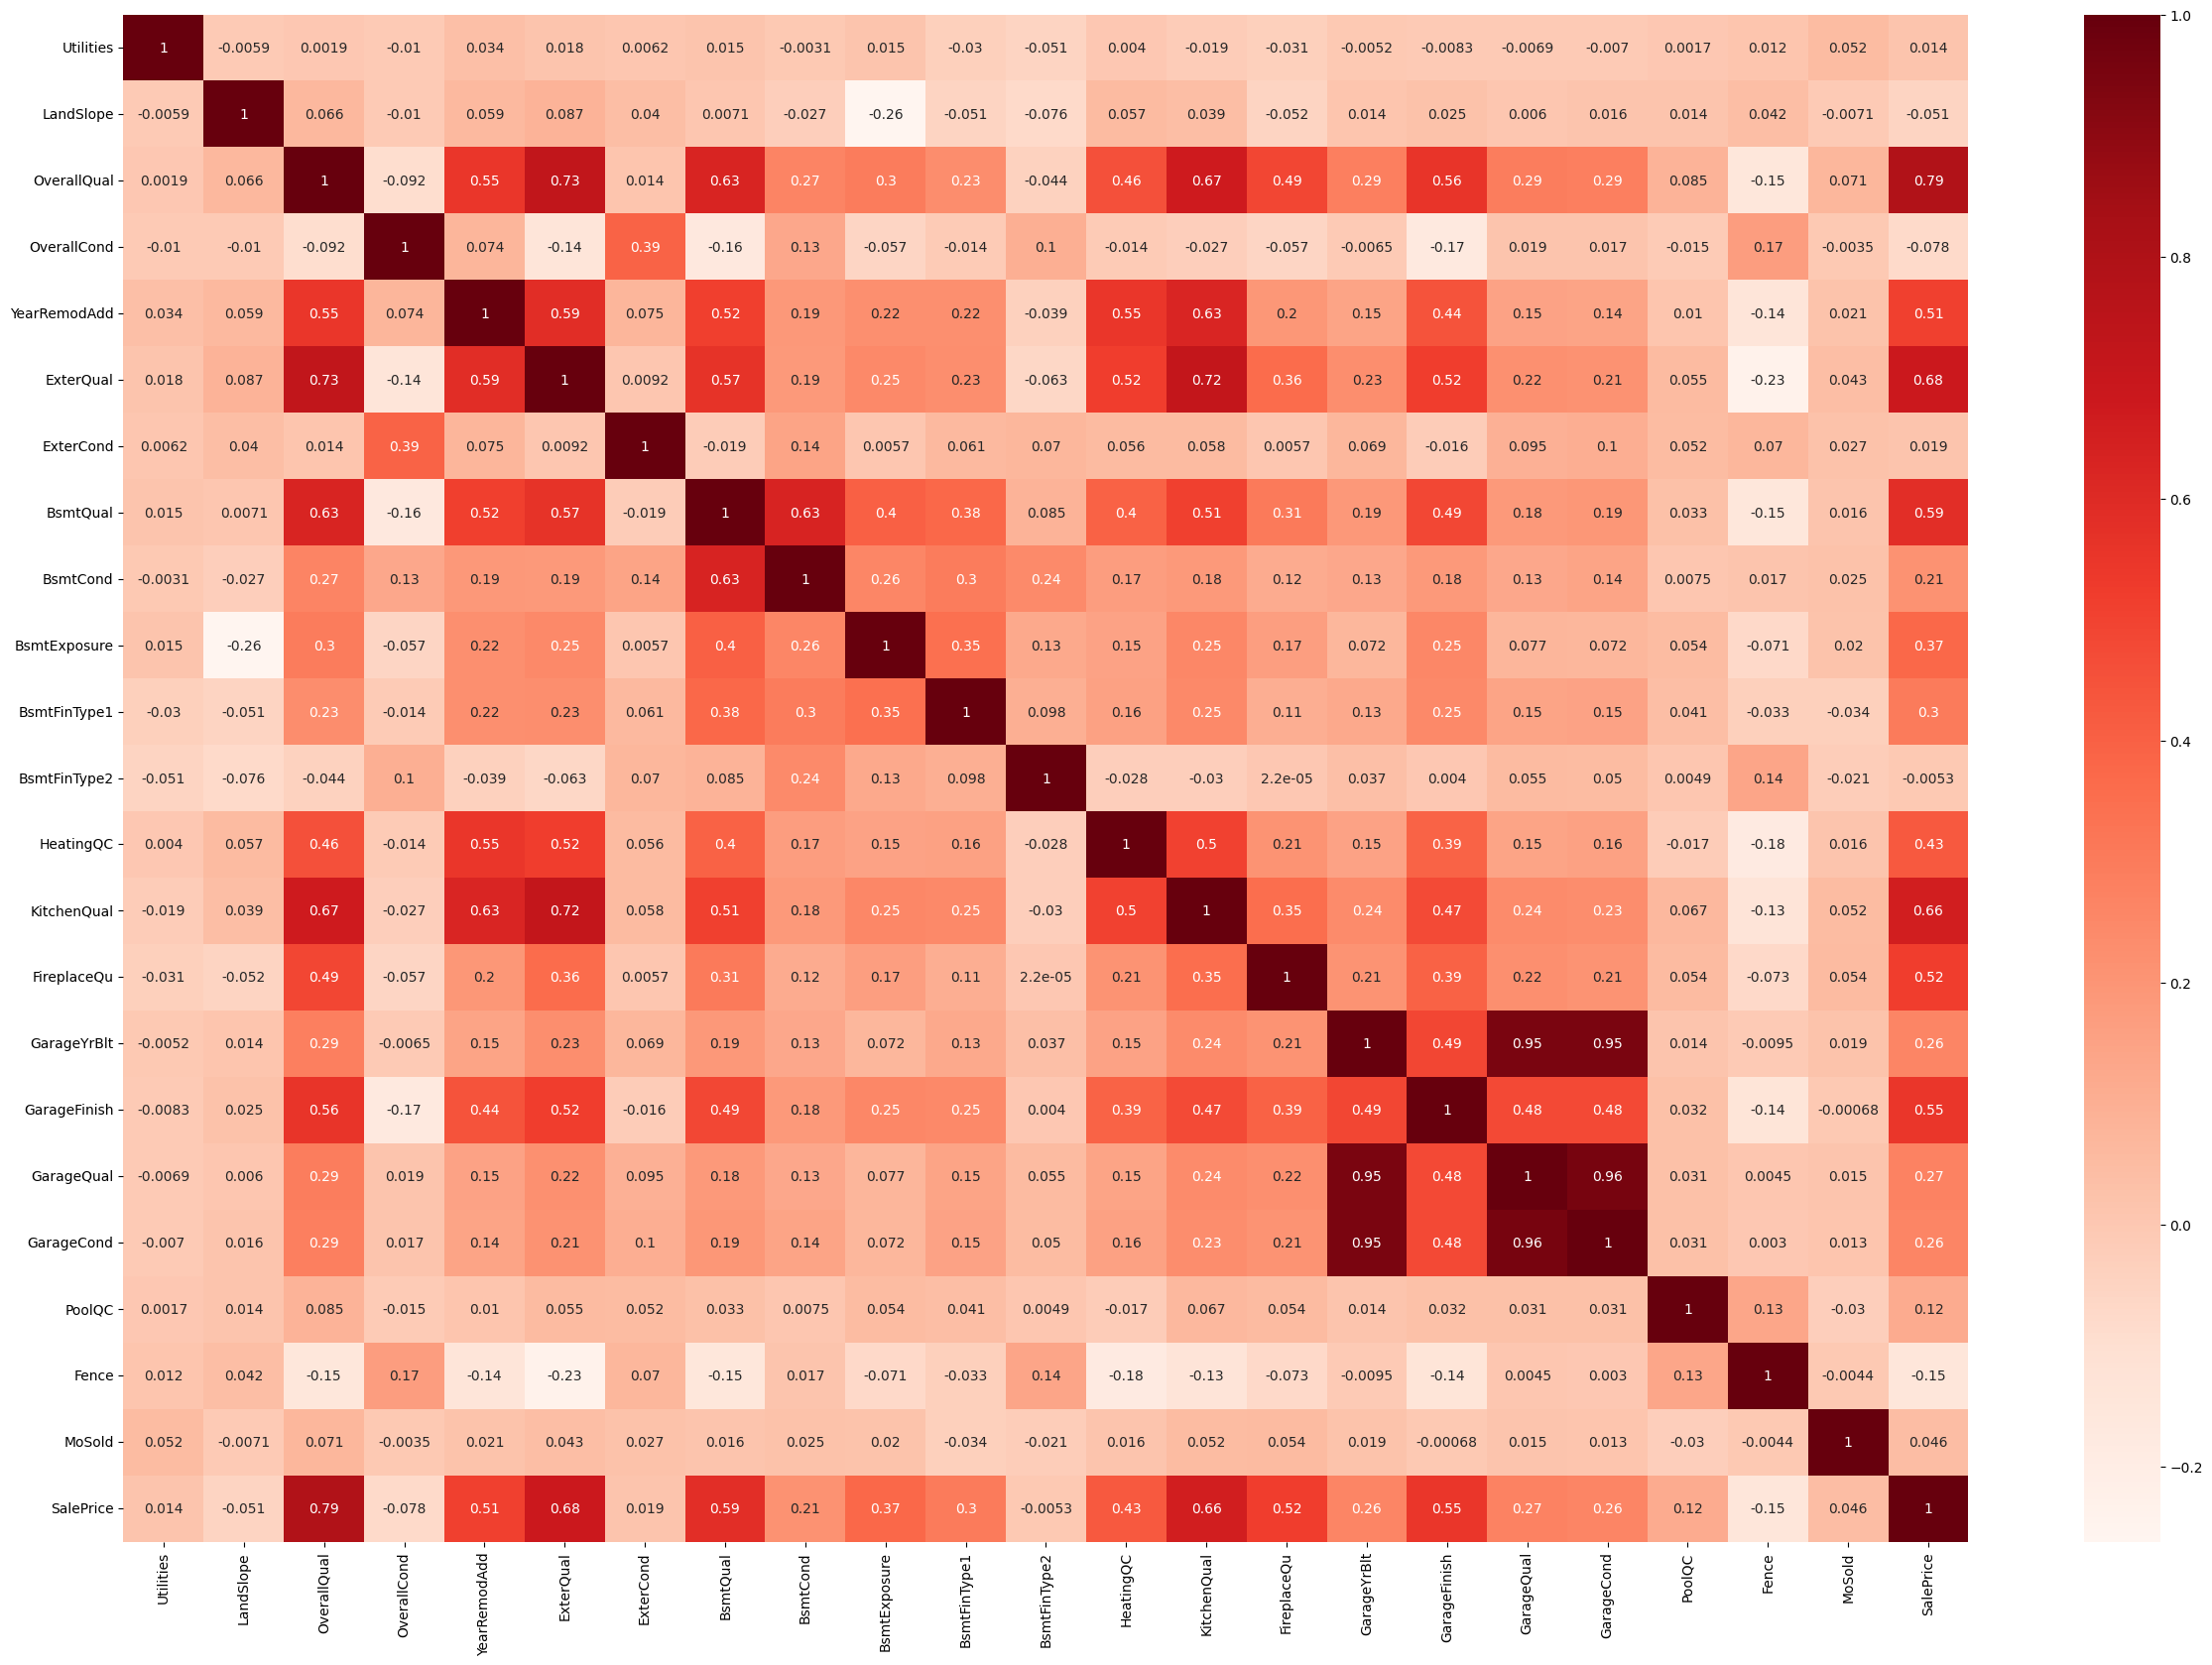

In [156]:
plt.figure(figsize=(30,20))
cor = scaled_final_df[ORDINAL_COLS + ['SalePrice']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

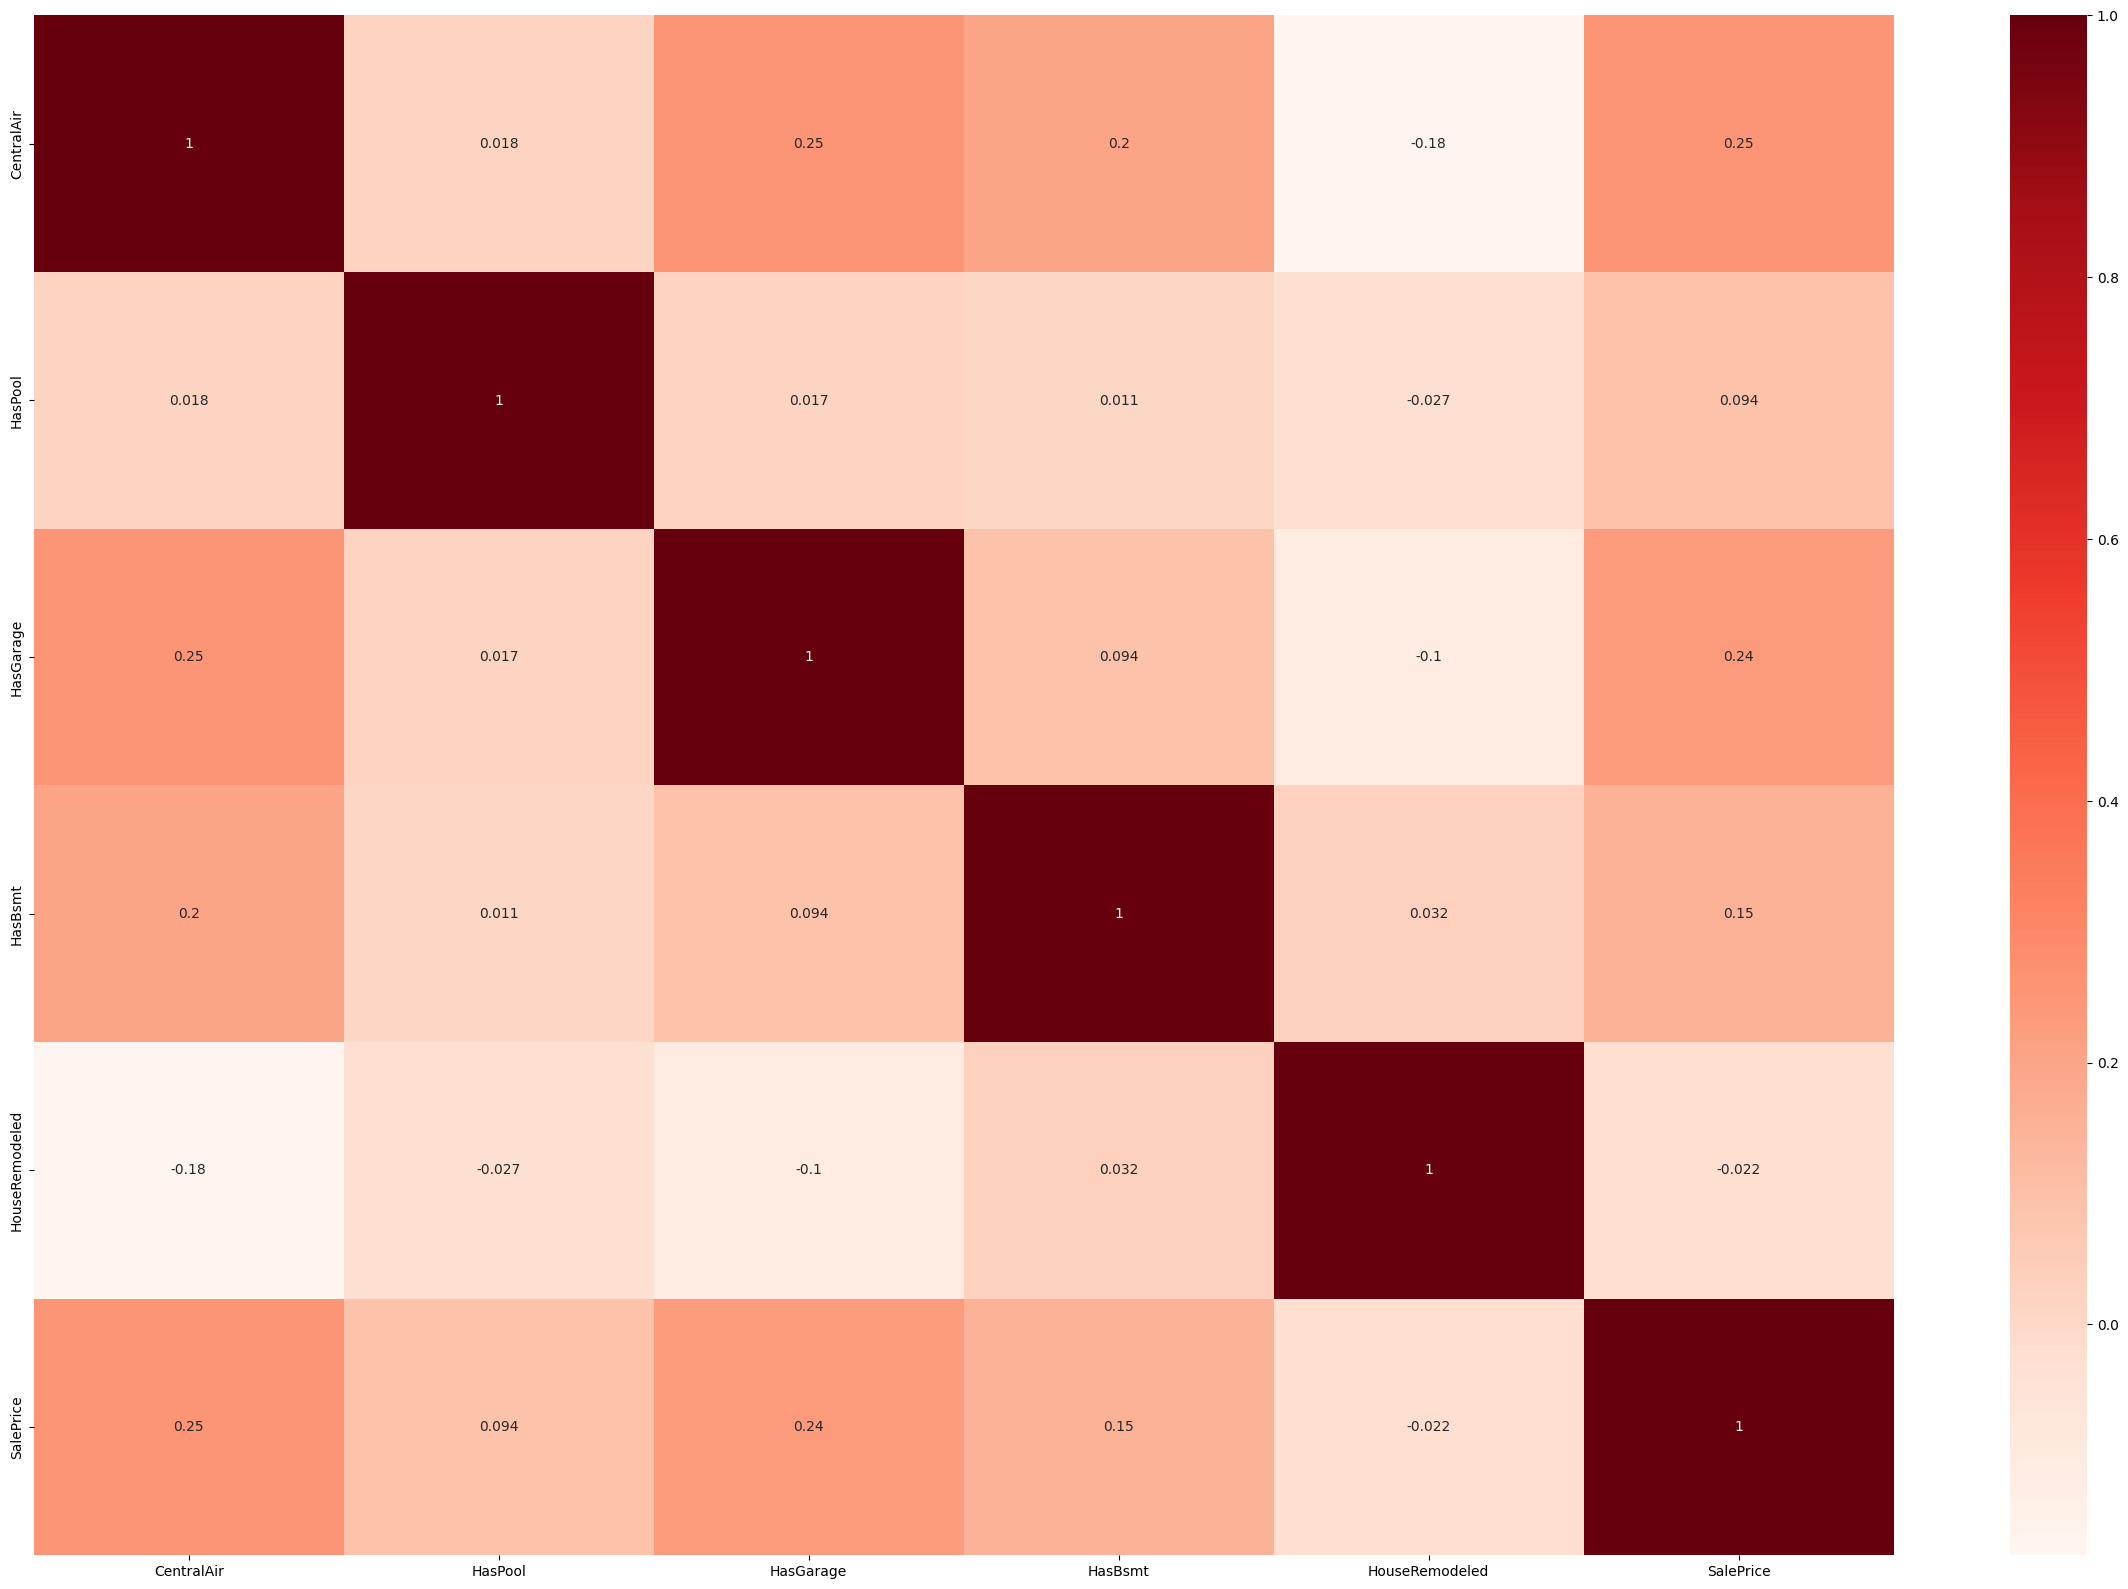

In [157]:
plt.figure(figsize=(30,20))
cor = scaled_final_df[BINARY_COLS + ['SalePrice']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Feature Selection

#### FIlter Method

In [167]:
correlation = scaled_final_df.corr()['SalePrice'].drop('SalePrice')

threshold = 0.5
selected_features_filter = correlation[correlation.abs() > threshold].sort_values(ascending=False)
print(selected_features_filter)

OverallQual     0.790982
TotalSF         0.761613
GrLivArea       0.695147
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
BsmtQual        0.585207
FullBath        0.560664
GarageFinish    0.549247
TotRmsAbvGrd    0.522355
FireplaceQu     0.520438
YearRemodAdd    0.507101
HouseAge       -0.523350
Name: SalePrice, dtype: float64


#### Wrapper Method

In [168]:
scaled_final_df.columns 

Index(['LotFrontage', 'LotArea', 'Utilities', 'LandSlope', 'OverallQual',
       'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       ...
       'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'MSSubClass',
       'HouseRemodeled', 'HasPool', 'HasGarage', 'HasBsmt'],
      dtype='object', length=152)

In [169]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

X = scaled_final_df.drop('SalePrice', axis=1)
y = scaled_final_df['SalePrice']

model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=16)
rfe.fit(X, y)


selected_features_wrapper = X.columns[rfe.support_]
print(selected_features_wrapper)


Index(['KitchenAbvGr', 'PoolArea', 'PoolQC', 'TotalSF', 'HasPool_1',
       'Condition2_PosN', 'RoofMatl_CompShg', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'SaleCondition_Partial',
       'MiscFeature_TenC', 'HasPool'],
      dtype='object')


In [170]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 16
selected_features_embedded = X.columns[indices[:top_n]]

for i in range(top_n):
    print(f"{selected_features_embedded[i]}: {importances[indices[i]]:.4f}")


TotalSF: 0.4389
OverallQual: 0.3387
HouseAge: 0.0224
GrLivArea: 0.0158
LotArea: 0.0127
MasVnrArea: 0.0122
KitchenQual: 0.0110
TotalBsmtFinSF: 0.0103
BsmtQual: 0.0103
YearRemodAdd: 0.0096
GarageArea: 0.0096
BsmtUnfSF: 0.0091
GarageCars: 0.0083
TotalPorchSF: 0.0070
LotFrontage: 0.0066
GarageYrBlt: 0.0064


In [171]:
all_selected = {
    'Filter': list(selected_features_filter.index),
    'Wrapper': list(selected_features_wrapper),
    'Embedded': list(selected_features_embedded)
}
comparison_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in all_selected.items()]))
print(comparison_df)

          Filter                Wrapper        Embedded
0    OverallQual           KitchenAbvGr         TotalSF
1        TotalSF               PoolArea     OverallQual
2      GrLivArea                 PoolQC        HouseAge
3      ExterQual                TotalSF       GrLivArea
4    KitchenQual              HasPool_1         LotArea
5     GarageCars        Condition2_PosN      MasVnrArea
6     GarageArea       RoofMatl_CompShg     KitchenQual
7       BsmtQual       RoofMatl_Membran  TotalBsmtFinSF
8       FullBath         RoofMatl_Metal        BsmtQual
9   GarageFinish          RoofMatl_Roll    YearRemodAdd
10  TotRmsAbvGrd       RoofMatl_Tar&Grv      GarageArea
11   FireplaceQu       RoofMatl_WdShake       BsmtUnfSF
12  YearRemodAdd       RoofMatl_WdShngl      GarageCars
13      HouseAge  SaleCondition_Partial    TotalPorchSF
14           NaN       MiscFeature_TenC     LotFrontage
15           NaN                HasPool     GarageYrBlt


In [172]:
selected_features = [
    "OverallQual",
    "TotalSF",
    "GrLivArea",
    "HouseAge",
    "GarageArea",
    "GarageCars",
    "KitchenQual",
    "BsmtQual",
    "YearRemodAdd",
    "LotArea",
    "TotalBsmtFinSF",
    "LotFrontage",
    "MasVnrArea",
    "TotalPorchSF"
]


In [173]:
scaled_final_df.to_csv('../data/train_scaled.csv', index=False)

In [174]:
scaled_final_df.shape

(1460, 152)